# Investigating Failure Modes and Enhancements of Physics-Informed Neural Networks for Power System Dynamics

## Uncertainty Quantification

#### Karan Kataria
#### Supervisor: Dr. Subhash Lakshminarayana

In [1]:
import os
import sys

# Add ODE_numerical_solver module to PATH variable
sys.path.insert(
    1,
    "/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/src/data"
)

sys.path.insert(
    2,
    "/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/src/pinn"
)

import numpy as np
import matplotlib.pyplot as plt
import torch
import scienceplots
from natsort import natsorted

from global_constants import *
from ODE_numerical_solver import swing_ODEs_solver

# Config matplotlib and define plot constants
plt.style.use("science")
plt.rcParams["text.usetex"] = True

In [2]:
PARAM: str = "inertia"
VARYING_PARAM_NOTATION: str = "$m$"
NETWORK: str = "vanilla_nn"

assert NETWORK == "pinn" or NETWORK == "vanilla_nn"

# Param dictionary
PARAM_DICT = {
    "DAMPING": [0.00015, 0.0015, 0.015, 0.15, 1.5],
    "INERTIA": [0.01, 0.1325, 0.250, 0.3775, 0.5],
    "PHYSICS_WEIGHT": [1e-3, 1e-2, 1e-1, 1e0, 1e1],
    "MECHANICAL_POWER": [0.0, 0.0475, 0.095 , 0.1425, 0.19]
}

# Specify the range of parameter values
PARAM_LIST: list[float] = PARAM_DICT[PARAM.upper()]

DAMPING: torch.Tensor = torch.tensor(data=[[0.15]])
# INERTIA: torch.Tensor = torch.tensor(data=[[0.25]])
PHYSICS_WEIGHT: torch.Tensor = torch.tensor(data=[[1.0]])
IC_WEIGHT: torch.Tensor = torch.tensor(data=[[1.0]])
MECHANICAL_POWER: torch.Tensor = torch.tensor(data=[[0.13]])
INITIAL_STATE: torch.tensor = torch.tensor(data=np.array([0.1, 0.1]), dtype=torch.float32)
EPOCHS: int = 15_000
EPOCHS_ADAM = 10_000

# Use TIMESTEP_FLOAT instead of TIMESTEP tensor due to floating-point errors
TIMESTEP_FLOAT = 0.1

STD: float = 1.0

# Path to save images and flag
PATH_TO_IM_DIR: str = "/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick"\
                    f"/dissertation_code/data/visualisations/loss_landscapes/{PARAM}/"

SAVE: bool = False

In [3]:
numerical_solutions_exact = []
numerical_solutions_noisy = []
numerical_domain = None

for param in PARAM_LIST:

    INERTIA: torch.Tensor = torch.tensor(data=[[param]])

    solution, noisy_solution, numerical_times = swing_ODEs_solver(
    initial_time=T0,
    initial_state=INITIAL_STATE.detach().numpy(),
    final_time=FINALTIME,
    timestep=TIMESTEP_FLOAT,
    inertia=INERTIA.item(),
    damping=DAMPING.item(),
    mechanical_power=MECHANICAL_POWER.item(),
    voltage_magnitude=VOLTAGE.item(),
    include_controllers=False,
    voltages=np.array([VOLTAGES.item()]),
    phase_angles=np.array([PHASE_ANGLES.item()]),
    susceptances=np.array([SUSCEPTANCES.item()]),
    file_name="test_run",
    save_output_to_file=False,
    controller_proportional=0.05,
    controller_integral=0.1
    )

    if numerical_domain is None:
        numerical_domain = numerical_times

    numerical_solutions_exact.append(solution)
    numerical_solutions_noisy.append(noisy_solution)

# Reshape numerical solutions into a rank-2 tensor of shape (No. of params values, 2, N)
numerical_solutions_exact = np.array(numerical_solutions_exact)
numerical_solutions_noisy = np.array(numerical_solutions_noisy)

In [4]:
os.chdir(
    "/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/"\
    f"dissertation_code/data/visualisations/loss_landscapes/{PARAM}/{NETWORK}"
)

In [5]:
pinn_preds_pa = []
pinn_preds_af = []

pa_label = []
af_label = []

if NETWORK == "pinn":

    pred_dir = os.getcwd()+"/pinn_pred_vs_rk45/"

    for file in os.listdir(pred_dir):
        npz = np.load(file=pred_dir+file)
        pinn_preds_pa.append(npz["pred"])
        pinn_preds_af.append(npz["pred_dot"])

    pinn_preds_pa = np.array(pinn_preds_pa)
    pinn_preds_af = np.array(pinn_preds_af)

    pinn_preds_pa_mean = np.mean(pinn_preds_pa, axis=0)
    pinn_preds_af_mean = np.mean(pinn_preds_af, axis=0)

    pinn_preds_pa_std = np.std(pinn_preds_pa, axis=0)
    pinn_preds_af_std = np.std(pinn_preds_af, axis=0)

else:

    numerical_domain = []

    pred_dir = os.getcwd()+"/nn_pred_vs_rk45/"
    
    for file in os.listdir(pred_dir):
        npz = np.load(file=pred_dir+file, allow_pickle=True)
        pinn_preds_pa.append(npz["pred"])
        pinn_preds_af.append(npz["pred_dot"])
        pa_label.append(npz["phase_angle_label"])
        af_label.append(npz["angular_frequency_label"])
        numerical_domain.append(npz["test_times"])

    pinn_preds_pa = np.array(pinn_preds_pa)
    pinn_preds_af = np.array(pinn_preds_af)

    pa_label = np.array(pa_label)
    af_label = np.array(af_label)

    pinn_preds_pa_mean = np.mean(pinn_preds_pa, axis=0)
    pinn_preds_af_mean = np.mean(pinn_preds_af, axis=0)

    pinn_preds_pa_std = np.std(pinn_preds_pa, axis=0)
    pinn_preds_af_std = np.std(pinn_preds_af, axis=0)

    numerical_domain = np.array(numerical_domain)[0, : , :].squeeze()

<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:39: SyntaxWarning: invalid escape sequence '\p'
<>:39: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\d'
<>:48: SyntaxWarning: invalid escape sequence '\d'
<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:39: SyntaxWarning: invalid escape sequence '\p'
<>:39: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\d'
<>:48: SyntaxWarning: invalid escape sequence '\d'
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_8320/1916324238.py:19: SyntaxWarning: invalid escape sequence '\p'
  label=f"$\pm$ {STD}"+"$\sigma$"
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_8320/1916324238.py:19: SyntaxWarning: invalid escape sequence '\s'
  label=f"$\pm$ {STD}"+"$\sigma$"
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_8320/1916

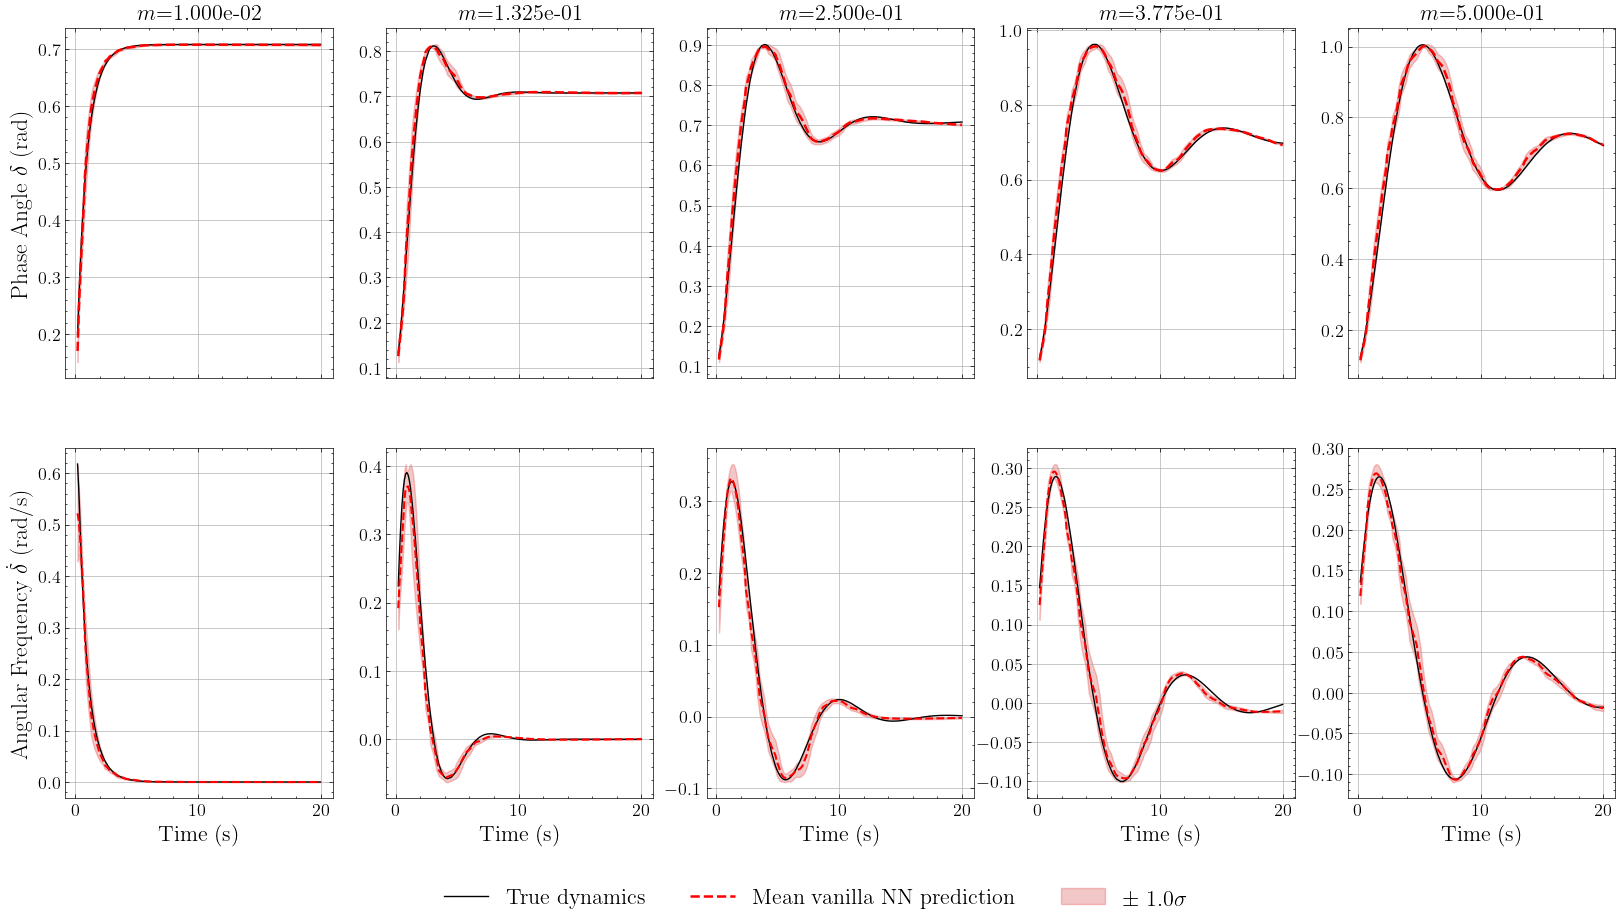

In [6]:
fig, ax = plt.subplots(2, len(PARAM_LIST), figsize=(20, 10), sharex=True)

for idx, param in enumerate(PARAM_LIST):
    
    if NETWORK == "pinn":
        ax[0, idx].plot(numerical_domain, numerical_solutions_exact[idx, 0, :], color="black", linestyle="-", label="True dynamics")
        ax[0, idx].plot(numerical_domain, pinn_preds_pa_mean[idx, :], color='red', linestyle='--', label='Mean PINN prediction', linewidth=1.8)
    else:
        ax[0, idx].plot(numerical_domain, pa_label[0, idx, :], color="black", linestyle="-", label="True dynamics")
        ax[0, idx].plot(numerical_domain, pinn_preds_pa_mean[idx, :], color='red', linestyle='--', label='Mean vanilla NN prediction', linewidth=1.8)
    
    ax[0, idx].fill_between(
        numerical_domain,
        pinn_preds_pa_mean[idx, :] + STD*pinn_preds_pa_std[idx, :],
        pinn_preds_pa_mean[idx, :] - STD*pinn_preds_pa_std[idx, :],
        edgecolor="#E41E1E",
        facecolor="#C82323",
        alpha=0.25,
        label=f"$\pm$ {STD}"+"$\sigma$"
    ) 
    ax[0, idx].grid()
    ax[0, idx].set_title(f'{VARYING_PARAM_NOTATION}='+f"{param:.3e}", fontsize=16)
    ax[0, idx].tick_params(axis='both', which='major', labelsize=13) 

    if NETWORK == "pinn":
        ax[1, idx].plot(numerical_domain, numerical_solutions_exact[idx, 1, :], color="black", linestyle="-", label="True dynamics")
        ax[1, idx].plot(numerical_domain, pinn_preds_af_mean[idx, :], color='red', linestyle='--', label='Mean PINN prediction', linewidth=1.5)
    else:
        ax[1, idx].plot(numerical_domain, af_label[0, idx, :], color="black", linestyle="-", label="True dynamics")
        ax[1, idx].plot(numerical_domain, pinn_preds_af_mean[idx, :], color='red', linestyle='--', label='Mean vanilla NN prediction', linewidth=1.5)
    
    ax[1, idx].fill_between(
        numerical_domain,
        pinn_preds_af_mean[idx, :] + STD*pinn_preds_af_std[idx, :],
        pinn_preds_af_mean[idx, :] - STD*pinn_preds_af_std[idx, :],
        edgecolor="#E41E1E",
        facecolor="#C82323",
        alpha=0.25,
        label=f"$\pm$ {STD}"+"$\sigma$"
    )
    ax[1, idx].set_xlabel("Time (s)", fontsize=16)
    ax[1, idx].grid()
    ax[1, idx].tick_params(axis='both', which='major', labelsize=13) 


    if idx == 0:
        ax[0, idx].set_ylabel("Phase Angle $\delta$ (rad)", fontsize=17)
        ax[1, idx].set_ylabel("Angular Frequency $\dot{\delta}$ (rad/s)", fontsize=17)

handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.02), fontsize=16)


exact_vs_pred_image: str = f"/{NETWORK}_vs_ground_truth_UQ.pdf"
if SAVE:
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+exact_vs_pred_image, format="pdf", bbox_inches="tight")

plt.show()

In [7]:
l2_errors_dir = os.getcwd()+"/l2_errors/"
abs_error = []
rel_error = []

for file in natsorted([file for file in os.listdir(l2_errors_dir) if (os.path.isfile(l2_errors_dir+file)) and (file != ".DS_Store")]):
    npz = np.load(file=l2_errors_dir+file)
    print(npz)
    abs_error.append(npz["absolute_errors"])
    rel_error.append(npz["relative_errors"])

abs_error = np.array(abs_error)
rel_error = np.array(rel_error)

abs_error_mean = np.mean(abs_error, axis=0)
rel_error_mean = np.mean(rel_error, axis=0)

abs_error_std = np.std(abs_error, axis=0)
rel_error_std = np.std(rel_error, axis=0)

NpzFile '/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/data/visualisations/loss_landscapes/inertia/vanilla_nn/l2_errors/abs_rel_errors_seed_0.npz' with keys: absolute_errors, relative_errors
NpzFile '/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/data/visualisations/loss_landscapes/inertia/vanilla_nn/l2_errors/abs_rel_errors_seed_10.npz' with keys: absolute_errors, relative_errors
NpzFile '/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/data/visualisations/loss_landscapes/inertia/vanilla_nn/l2_errors/abs_rel_errors_seed_20.npz' with keys: absolute_errors, relative_errors
NpzFile '/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/data/visualisations/loss_landscapes/inertia/vanilla_nn/l2_errors/abs_rel_errors_seed_30.npz' with keys: absolute_errors, relative_errors
NpzFile '/Users/karankataria/Library/CloudStorage/OneDrive-Univer

<>:24: SyntaxWarning: invalid escape sequence '\%'
<>:33: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\%'
<>:33: SyntaxWarning: invalid escape sequence '\s'
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_8320/1119524245.py:24: SyntaxWarning: invalid escape sequence '\%'
  ax_twin.set_ylabel("$L_2$ Relative Error (\%)", fontsize=16)
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_8320/1119524245.py:33: SyntaxWarning: invalid escape sequence '\s'
  label=fr"$\pm$ {STD_ABS_REL_ERR}"+"$\sigma$"


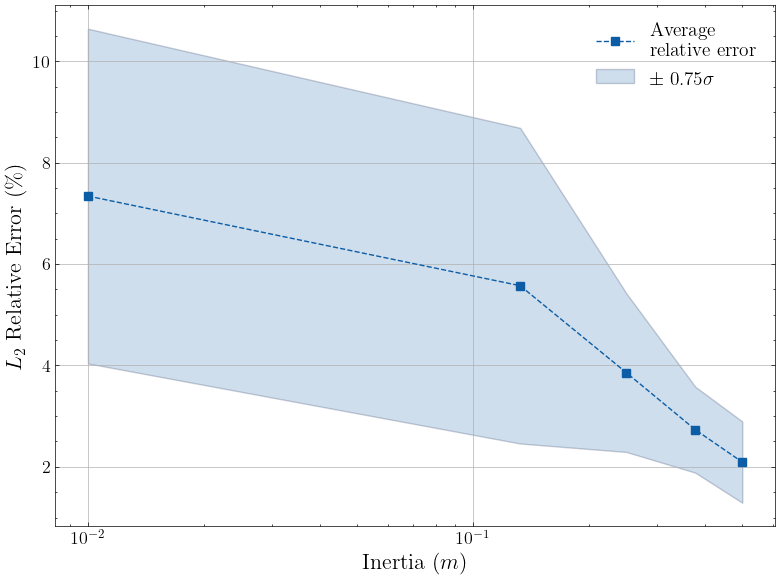

In [8]:
STD_ABS_REL_ERR: float = 0.75

fig, ax_twin = plt.subplots(1, 1, figsize=(8, 6))

# ax.loglog(PARAM_LIST, abs_error_mean, marker='s', linestyle='--', label="Average\nabsolute error")    
# ax.set_xlabel(f"{PARAM.title()} ({VARYING_PARAM_NOTATION})", fontsize=15)
# ax.set_ylabel("$L_2$ Absolute Error", fontsize=15)
# ax.fill_between(
#     PARAM_LIST,
#     abs_error_mean + STD_ABS_REL_ERR*abs_error_std,
#     abs_error_mean - STD_ABS_REL_ERR*abs_error_std,
#     # edgecolor="#2353EF",
#     # facecolor="#0E06A0",
#     alpha=0.25,
#     label=fr"$\pm$ {STD_ABS_REL_ERR}"+"$\sigma$"
# ) 
# ax.grid()
# ax.legend(fontsize=14)


# ax_twin = ax.twinx()
ax_twin.semilogx(PARAM_LIST, rel_error_mean*100, marker='s', linestyle='--', label="Average\nrelative error")    
ax_twin.set_xlabel(f"{PARAM.replace("_", " ").title()} ({VARYING_PARAM_NOTATION})", fontsize=16)
ax_twin.set_ylabel("$L_2$ Relative Error (\%)", fontsize=16)
ax_twin.grid()
ax_twin.fill_between(
    PARAM_LIST,
    rel_error_mean*100 + STD_ABS_REL_ERR*rel_error_std*100,
    rel_error_mean*100 - STD_ABS_REL_ERR*rel_error_std*100,
    edgecolor="#02103E",
    # facecolor="#0E06A0",
    alpha=0.2,
    label=fr"$\pm$ {STD_ABS_REL_ERR}"+"$\sigma$"
) 
ax_twin.legend(fontsize=14)
ax_twin.tick_params(axis='both', which='major', labelsize=13) 

plt.subplots_adjust(wspace=1.5)
plt.tight_layout()

l2_rel_error: str = f"/{NETWORK}_relative_test_error_UQ.pdf"
if SAVE:
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+l2_rel_error, format="pdf", bbox_inches="tight")

plt.show()
# test_error: str = f"{PARAM}_l2_test_error_random_seed_{SEED}.pdf"


In [9]:
print(f"Table of relative errors (%) per seed (rows) and param (columns):\n\n{rel_error*100}\n")
print(f"Average relative loss per seed for all parameter values:\n\n{np.mean(rel_error*100, axis=1).T}")

Table of relative errors (%) per seed (rows) and param (columns):

[[ 9.69750658  2.69703325  2.09831242  2.66177468  1.05638327]
 [14.96886611  6.78575486  7.73675367  4.41848747  4.03856561]
 [ 3.97114567 13.17703426  4.2687498   3.51938121  1.43274553]
 [ 4.06700522  1.89909935  2.95697711  1.38738966  1.52643342]
 [ 4.00801003  3.31069231  2.23097522  1.67749766  2.41199471]]

Average relative loss per seed for all parameter values:

[3.64220204 7.58968554 5.2738113  2.36738095 2.72783399]


<>:14: SyntaxWarning: invalid escape sequence '\%'
<>:14: SyntaxWarning: invalid escape sequence '\%'
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_8320/704265183.py:14: SyntaxWarning: invalid escape sequence '\%'
  ax.set_ylabel("$L_{2}$ Relative Error (\%)", fontsize=16)


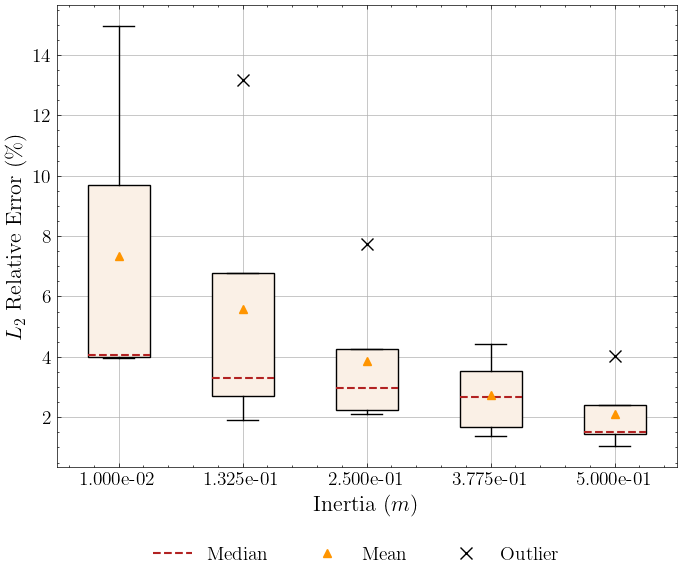

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.boxplot(
    rel_error*100,
    showmeans=True,
    medianprops=dict(linestyle="--", linewidth=1.5, color="firebrick", label="Median"),
    flierprops=dict(marker="x", markersize=8, color="black", label="Outlier"),
    meanprops=dict(markersize=6, label="Mean"),
    patch_artist=True,
    boxprops = dict(facecolor = "linen")
)

ax.set_xlabel(f"{PARAM.replace("_", " ").title()} ({VARYING_PARAM_NOTATION})", fontsize=16)
ax.set_ylabel("$L_{2}$ Relative Error (\%)", fontsize=16)
ax.set_xticks(range(1, len(PARAM_LIST)+1))
ax.set_xticklabels([f"{val:.3e}" for val in PARAM_LIST])
ax.tick_params(axis="both", which="major", labelsize=14) 
ax.grid()

handles, labels = ax.get_legend_handles_labels()

fig.legend(
    dict(zip(labels, handles)).values(),
    dict(zip(labels, handles)).keys(),
    loc="lower center",
    ncol=3,
    bbox_to_anchor=(0.5, -0.08),
    fontsize=14
)

rel_error_box_plot: str = f"/{NETWORK}_res_error_boxplot.pdf"

if SAVE:
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+rel_error_box_plot, format="pdf", bbox_inches="tight")

plt.show()

In [11]:
rel_error_per_epoch = os.getcwd()+"/rel_error_per_epoch/"
rel_error_test = []

for file in os.listdir(rel_error_per_epoch):
    npz = np.load(file=rel_error_per_epoch+file)
    rel_error_test.append(npz["test_loss"])

rel_error_test = np.array(rel_error_test)
print(rel_error_test.shape)

rel_error_test_mean = np.mean(rel_error_test, axis=0)

rel_error_test_std = np.std(rel_error_test, axis=0)

(5, 5, 15000)


<>:23: SyntaxWarning: invalid escape sequence '\%'
<>:23: SyntaxWarning: invalid escape sequence '\%'
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_8320/429156862.py:23: SyntaxWarning: invalid escape sequence '\%'
  ax.set_ylabel("$L_2$ Relative Test Error (\%)", fontsize=16)


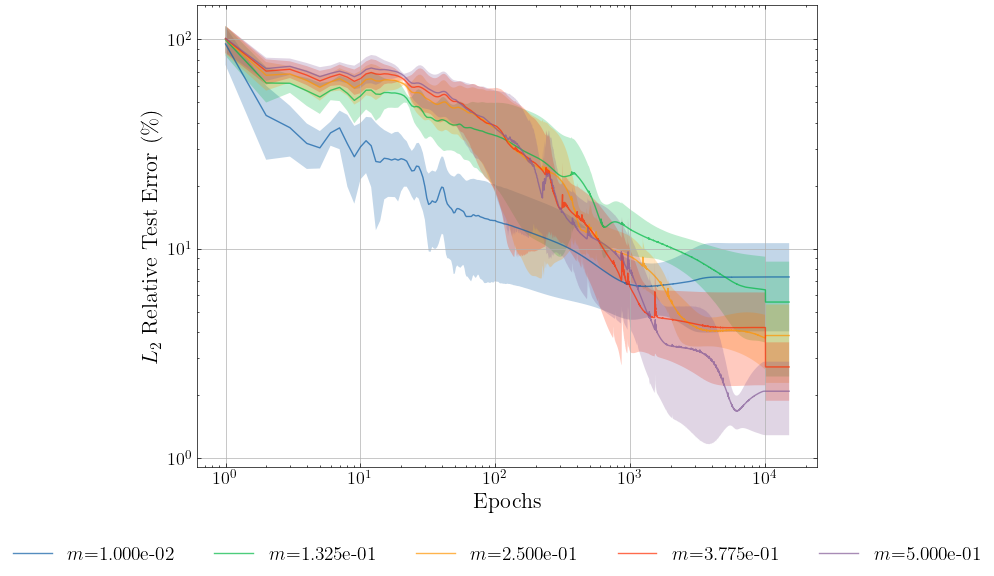

In [12]:
STD_REL_ERR_PER_EPOCH: float = 0.75

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for idx, param in enumerate(PARAM_LIST):
    ax.loglog(
        range(1, EPOCHS+1),
        rel_error_test_mean[idx, :]*100,
        alpha=0.7,
        label=f"{VARYING_PARAM_NOTATION}={param:.3e}"
    )

    ax.fill_between(
        range(1, EPOCHS+1),
        rel_error_test_mean[idx, :]*100 + STD_REL_ERR_PER_EPOCH*rel_error_test_std[idx, :]*100,
        rel_error_test_mean[idx, :]*100 - STD_REL_ERR_PER_EPOCH*rel_error_test_std[idx, :]*100,
        # edgecolor="#2353EF",
        # facecolor="#0E06A0",
        alpha=0.25,
        # label=f"+/- {0.5}"+"$\sigma$"
    ) 

ax.set_ylabel("$L_2$ Relative Test Error (\%)", fontsize=16)
ax.set_xlabel("Epochs", fontsize=16)
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=13) 

# ax.legend(loc="best", fontsize=15, bbox_to_anchor=(1.3, 0.6), borderaxespad=0.12)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(PARAM_LIST), bbox_to_anchor=(0.5, -0.08), fontsize=14)

plt.show()

In [13]:
training_loss = os.getcwd()+"/training_loss/"

if NETWORK == "pinn":
    residual_loss_per_epoch = []
    data_loss_per_epoch = []
    total_loss_per_epoch = []

    for file in os.listdir(training_loss):
        npz = np.load(file=training_loss+file)
        residual_loss_per_epoch.append(npz["residual_loss"])
        data_loss_per_epoch.append(npz["data_loss"])
        total_loss_per_epoch.append(npz["total_loss"])

    residual_loss_per_epoch = np.array(residual_loss_per_epoch)
    data_loss_per_epoch = np.array(data_loss_per_epoch)
    total_loss_per_epoch = np.array(total_loss_per_epoch)

    print(total_loss_per_epoch.shape)
    absolute_diff = np.abs(data_loss_per_epoch - residual_loss_per_epoch)

    residual_loss_per_epoch_mean = np.mean(residual_loss_per_epoch, axis=0)
    data_loss_per_epoch_mean = np.mean(data_loss_per_epoch, axis=0)
    total_loss_per_epoch_mean = np.mean(total_loss_per_epoch, axis=0)
    absolute_diff_mean = np.mean(absolute_diff, axis=0)

    residual_loss_per_epoch_std = np.std(residual_loss_per_epoch, axis=0)
    data_loss_per_epoch_std = np.std(data_loss_per_epoch, axis=0)
    total_loss_per_epoch_std = np.std(total_loss_per_epoch, axis=0)
    absolute_diff_std = np.mean(absolute_diff, axis=0)

else:
    total_loss_per_epoch = []

    for file in os.listdir(training_loss):
        npz = np.load(file=training_loss+file)
        total_loss_per_epoch.append(npz["total_loss"])

    total_loss_per_epoch = np.array(total_loss_per_epoch)

    print(total_loss_per_epoch.shape)

    total_loss_per_epoch_mean = np.mean(total_loss_per_epoch, axis=0)

    total_loss_per_epoch_std = np.std(total_loss_per_epoch, axis=0)

(5, 5, 15000)


<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\p'
<>:37: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\p'
<>:47: SyntaxWarning: invalid escape sequence '\s'
<>:70: SyntaxWarning: invalid escape sequence '\m'
<>:81: SyntaxWarning: invalid escape sequence '\p'
<>:81: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\p'
<>:37: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\p'
<>:47: SyntaxWarning: invalid escape sequence '\s'
<>:70: SyntaxWarning: invalid escape sequence '\m'
<>:81: SyntaxWarning: invalid escape sequence '\p'
<>:81: SyntaxWarning: invalid escape sequence '\s'
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_8320/3849128345.py:13: 

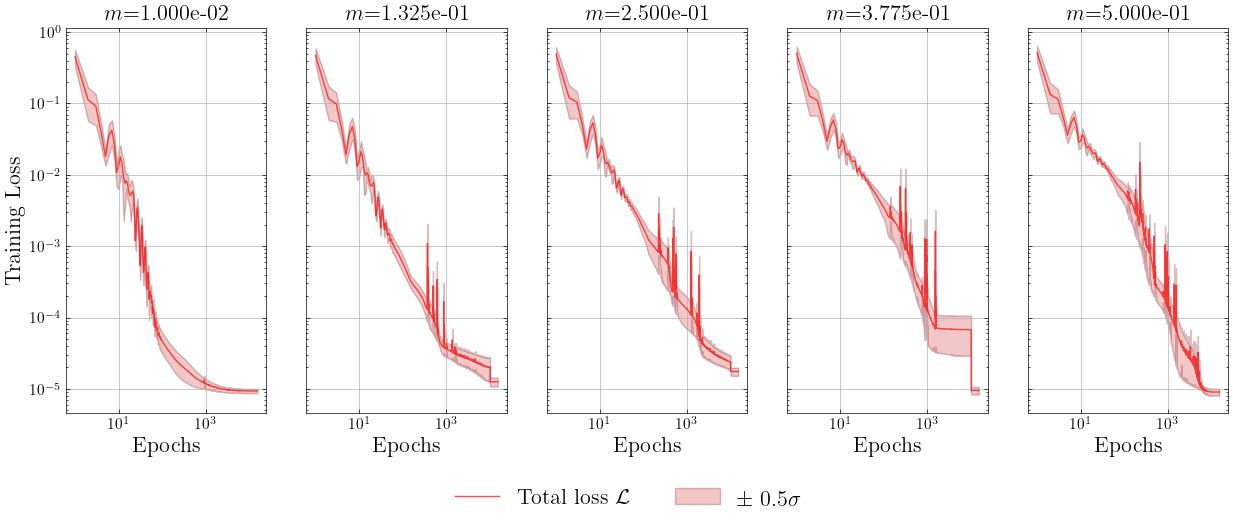

In [14]:
STD = 0.5

fig, ax = plt.subplots(1, len(PARAM_LIST), figsize=(15, 5), sharey=True)

if NETWORK == "pinn":

    for idx, param in enumerate(PARAM_LIST):

        ax[idx].loglog(
            range(1, EPOCHS+1),
            data_loss_per_epoch_mean[idx, :],
            alpha=0.7,
            label="Mean data loss $\mathcal{L}_{\mathrm{data}}$"
        )

        ax[idx].semilogy(
            range(1, EPOCHS+1),
            residual_loss_per_epoch_mean[idx, :],
            color="red",
            alpha=0.7,
            label="Mean residual loss $\mathcal{L}_{\mathrm{physics}}$"
        )

        # ax[idx].semilogy(
        #     range(1, EPOCHS+1),
        #     total_loss_per_epoch_mean[idx, :],
        #     alpha=0.7,
        #     label="Total loss $\mathcal{L}$"
        # )

        ax[idx].fill_between(
            range(1, EPOCHS+1),
            data_loss_per_epoch_mean[idx, :] - STD*data_loss_per_epoch_std[idx, :],
            data_loss_per_epoch_mean[idx, :] + STD*data_loss_per_epoch_std[idx, :],
            alpha=0.25,
            # edgecolor="#02103E",
            label=f"$\pm$ {STD}"+"$\sigma$"
        )

        ax[idx].fill_between(
            range(1, EPOCHS+1),
            residual_loss_per_epoch_mean[idx, :] - STD*residual_loss_per_epoch_std[idx, :],
            residual_loss_per_epoch_mean[idx, :] + STD*residual_loss_per_epoch_std[idx, :],
            edgecolor="#690404",
            facecolor="#C82323",
            alpha=0.25,
            label=f"$\pm$ {STD}"+"$\sigma$"
        )

        if idx == 0:
            ax[idx].set_ylabel("Training Loss", fontsize=16)

        ax[idx].set_xlabel("Epochs", fontsize=16)
        ax[idx].grid()
        ax[idx].set_title(f'{VARYING_PARAM_NOTATION}='+f"{param:.3e}", fontsize=16)
        ax[idx].tick_params(axis='both', which='major', labelsize=11) 
        

    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.12), fontsize=16)

else:

    for idx, param in enumerate(PARAM_LIST):

        ax[idx].loglog(
            range(1, EPOCHS+1),
            total_loss_per_epoch_mean[idx, :],
            alpha=0.7,
            label="Total loss $\mathcal{L}$",
            color="red"
        )

        ax[idx].fill_between(
            range(1, EPOCHS+1),
            total_loss_per_epoch_mean[idx, :] - STD*total_loss_per_epoch_std[idx, :],
            total_loss_per_epoch_mean[idx, :] + STD*total_loss_per_epoch_std[idx, :],
            edgecolor="#690404",
            facecolor="#C82323",
            alpha=0.25,
            label=f"$\pm$ {STD}"+"$\sigma$"
        )

        if idx == 0:
            ax[idx].set_ylabel("Training Loss", fontsize=16)

        ax[idx].set_xlabel("Epochs", fontsize=16)
        ax[idx].grid()
        ax[idx].set_title(f'{VARYING_PARAM_NOTATION}='+f"{param:.3e}", fontsize=16)
        ax[idx].tick_params(axis='both', which='major', labelsize=11) 

    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.12), fontsize=16)

res_loss_vs_data_loss_per_epoch: str = f"/{NETWORK}_res_loss_vs_data_loss.pdf"

if SAVE:
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+res_loss_vs_data_loss_per_epoch, format="pdf", bbox_inches="tight")

plt.show()

In [15]:
STD = 0.9

if NETWORK == "pinn":
    fig, ax = plt.subplots(1, len(PARAM_LIST), figsize=(22, 6), sharey=True)

    for idx, param in enumerate(PARAM_LIST):

        ax[idx].semilogy(
            range(1, EPOCHS+1),
            absolute_diff_mean[idx, :],
            alpha=0.7,
            label="Mean absolute difference"
        )

        print(absolute_diff_mean[idx, :] - STD*absolute_diff_std[idx, :])

        ax[idx].fill_between(
            range(1, EPOCHS+1),
            (absolute_diff_mean[idx, :] - STD*absolute_diff_std[idx, :]),
            (absolute_diff_mean[idx, :] + STD*absolute_diff_std[idx, :]),
            alpha=0.25,
            label=fr"$\pm$ {STD}"+"$\sigma$"
        )

        if idx == 0:
            ax[idx].set_ylabel(r"$|\mathcal{L}_{\mathrm{physics}}$ - $\mathcal{L}_{\mathrm{data}}|$", fontsize=16)

        ax[idx].set_xlabel("Epochs", fontsize=16)
        ax[idx].grid()
        ax[idx].set_title(f'{VARYING_PARAM_NOTATION}='+f"{param:.3e}", fontsize=16)

    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.08), fontsize=16)

    plt.show()

<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_8320/1457464633.py:22: SyntaxWarning: invalid escape sequence '\s'
  label=fr"$\pm$ {STD}"+"$\sigma$"


In [16]:
gradient_norm_per_param = os.getcwd()+"/gradient_norms/"
grad_norms = []

for file in os.listdir(gradient_norm_per_param):
    npz = np.load(file=gradient_norm_per_param+file)
    grad_norms.append(npz["grad_norms"])

grad_norms = np.array(grad_norms)
print(grad_norms.shape)

grad_norms_mean = np.mean(grad_norms, axis=0)

grad_norms_std = np.std(grad_norms, axis=0)

(5, 5, 10000)


<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_8320/2699185027.py:18: SyntaxWarning: invalid escape sequence '\s'
  label=fr"$\pm$ {GRAD_STD}"+"$\sigma$"


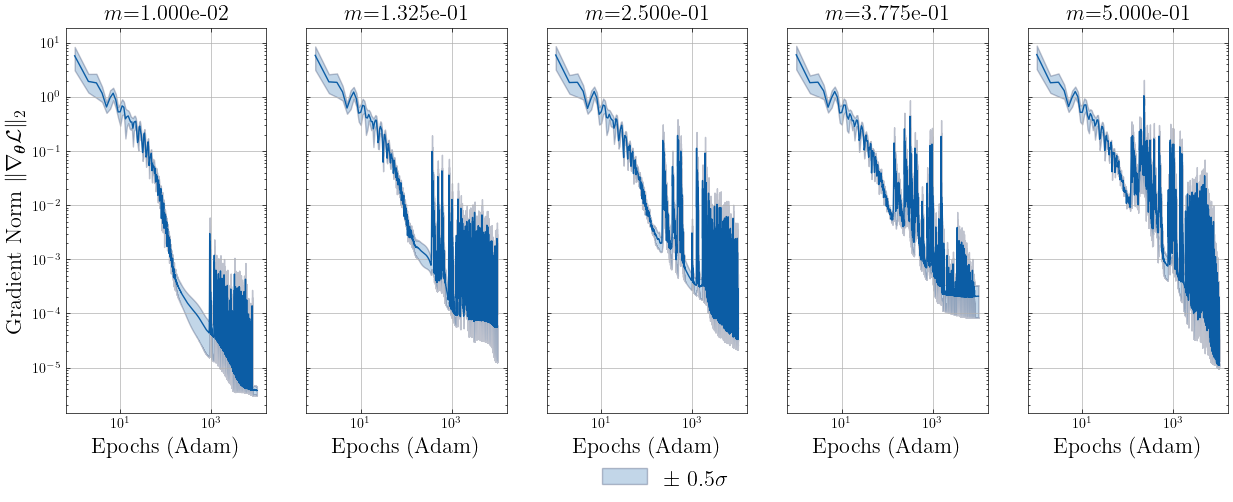

In [17]:
GRAD_STD: float = .5

fig, ax = plt.subplots(1, len(PARAM_LIST), figsize=(15, 5), sharey=True)

for idx, param in enumerate(PARAM_LIST):
    ax[idx].loglog(
        range(1, EPOCHS_ADAM+1),
        grad_norms_mean[idx, :],
        alpha=1.0
    )

    ax[idx].fill_between(
        range(1, EPOCHS_ADAM+1),
        (grad_norms_mean[idx, :] - GRAD_STD*grad_norms_std[idx, :]),
        (grad_norms_mean[idx, :] + GRAD_STD*grad_norms_std[idx, :]),
        alpha=0.25,
        edgecolor="#02103E",
        label=fr"$\pm$ {GRAD_STD}"+"$\sigma$"
    )

    if idx == 0:
        ax[idx].set_ylabel(r"Gradient Norm $\lVert \nabla_{\boldsymbol{\theta}}\mathcal{L}\rVert_{2}$", fontsize=16)

    ax[idx].set_title(f'{VARYING_PARAM_NOTATION}='+f"{param:.3e}", fontsize=16)
    ax[idx].set_xlabel("Epochs (Adam)", fontsize=16)
    ax[idx].grid()

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=1, bbox_to_anchor=(0.525, -0.08), fontsize=16)

grad_norms_im: str = f"/{NETWORK}_gradient_norms.pdf"

if SAVE:
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+grad_norms_im, format="pdf", bbox_inches="tight")

plt.show()

<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:52: SyntaxWarning: invalid escape sequence '\p'
<>:52: SyntaxWarning: invalid escape sequence '\s'
<>:62: SyntaxWarning: invalid escape sequence '\p'
<>:62: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:52: SyntaxWarning: invalid escape sequence '\p'
<>:52: SyntaxWarning: invalid escape sequence '\s'
<>:62: SyntaxWarning: invalid escape sequence '\p'
<>:62: SyntaxWarning: invalid escape sequence '\s'
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_8320/4224599514.py:21: SyntaxWarning: invalid escape sequence '\s'
  label=fr"$\pm$ {GRAD_STD}"+"$\sigma$"
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_8320/4224599514.py:28: SyntaxWarning: invalid escape sequence

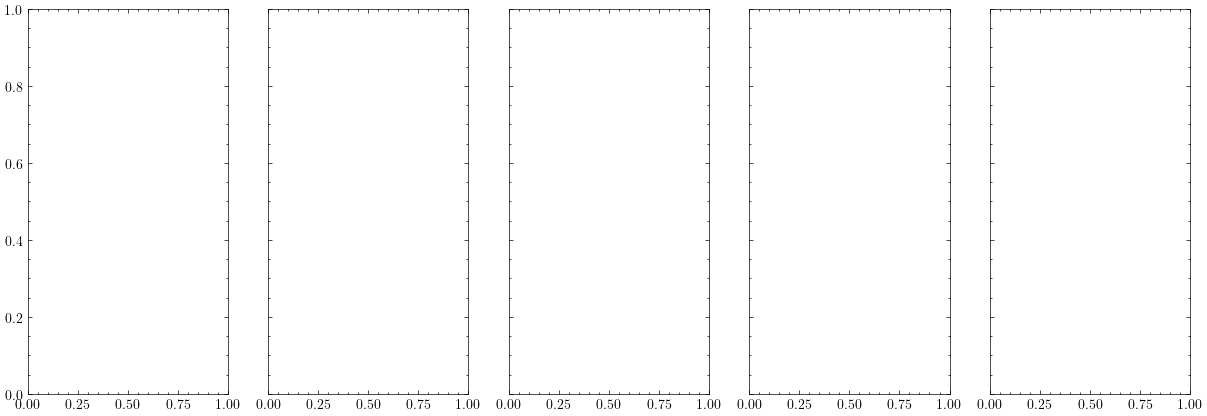

In [18]:
STD = 0.5

fig, ax = plt.subplots(1, len(PARAM_LIST), figsize=(15, 5), sharey=True)

if NETWORK == "pinn":

    for idx, param in enumerate(PARAM_LIST):

        ax[idx].loglog(
        range(1, EPOCHS_ADAM+1),
        grad_norms_mean[idx, :],
        alpha=1.0
        )

        ax[idx].fill_between(
            range(1, EPOCHS_ADAM+1),
            (grad_norms_mean[idx, :] - GRAD_STD*grad_norms_std[idx, :]),
            (grad_norms_mean[idx, :] + GRAD_STD*grad_norms_std[idx, :]),
            alpha=0.25,
            edgecolor="#02103E",
            label=fr"$\pm$ {GRAD_STD}"+"$\sigma$"
        )

        ax[idx].loglog(
            range(1, EPOCHS+1),
            data_loss_per_epoch_mean[idx, :],
            alpha=0.7,
            label="Mean data loss $\mathcal{L}_{\mathrm{data}}$"
        )

        ax[idx].loglog(
            range(1, EPOCHS+1),
            residual_loss_per_epoch_mean[idx, :],
            color="red",
            alpha=0.7,
            label="Mean residual loss $\mathcal{L}_{\mathrm{physics}}$"
        )

        # ax[idx].semilogy(
        #     range(1, EPOCHS+1),
        #     total_loss_per_epoch_mean[idx, :],
        #     alpha=0.7,
        #     label="Total loss $\mathcal{L}$"
        # )

        ax[idx].fill_between(
            range(1, EPOCHS+1),
            data_loss_per_epoch_mean[idx, :] - STD*data_loss_per_epoch_std[idx, :],
            data_loss_per_epoch_mean[idx, :] + STD*data_loss_per_epoch_std[idx, :],
            alpha=0.25,
            # edgecolor="#02103E",
            label=f"$\pm$ {STD}"+"$\sigma$"
        )

        ax[idx].fill_between(
            range(1, EPOCHS+1),
            residual_loss_per_epoch_mean[idx, :] - STD*residual_loss_per_epoch_std[idx, :],
            residual_loss_per_epoch_mean[idx, :] + STD*residual_loss_per_epoch_std[idx, :],
            edgecolor="#690404",
            facecolor="#C82323",
            alpha=0.25,
            label=f"$\pm$ {STD}"+"$\sigma$"
        )

        if idx == 0:
            ax[idx].set_ylabel("Training Loss", fontsize=16)

        ax[idx].set_xlabel("Epochs", fontsize=16)
        ax[idx].grid()
        ax[idx].set_title(f'{VARYING_PARAM_NOTATION}='+f"{param:.3e}", fontsize=16)
        ax[idx].tick_params(axis='both', which='major', labelsize=11) 
        

    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.12), fontsize=16)

# if SAVE:
#     print("Saving...")
#     plt.savefig(fname=PATH_TO_IM_DIR+res_loss_vs_data_loss_per_epoch, format="pdf", bbox_inches="tight")

# plt.show()

## Semi-Supervised Learning Analysis

In [19]:
l2_errors_dir_semi = os.getcwd()+"/l2_errors/semi_supervised/"

if NETWORK == "pinn":
    abs_error_semi_supervised = []
    rel_error_semi_supervised = []

    for file in natsorted([file for file in os.listdir(l2_errors_dir_semi) if os.path.isfile(l2_errors_dir_semi+file)]):
        npz = np.load(file=l2_errors_dir_semi+file)
        print(npz)
        abs_error_semi_supervised.append(npz["absolute_errors"])
        rel_error_semi_supervised.append(npz["relative_errors"])

    abs_error_semi_supervised = np.array(abs_error_semi_supervised)
    rel_error_semi_supervised = np.array(rel_error_semi_supervised)

    print(rel_error_semi_supervised*100)

else:
    abs_error_semi_supervised = []
    rel_error_semi_supervised = []

    for file in natsorted([file for file in os.listdir(l2_errors_dir_semi) if os.path.isfile(l2_errors_dir_semi+file) and file != ".DS_Store"]):
        npz = np.load(file=l2_errors_dir_semi+file)
        print(npz)
        abs_error_semi_supervised.append(npz["absolute_errors"])
        rel_error_semi_supervised.append(npz["relative_errors"])

    abs_error_semi_supervised = np.array(abs_error_semi_supervised)
    rel_error_semi_supervised = np.array(rel_error_semi_supervised)

    print(rel_error_semi_supervised*100)

NpzFile '/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/data/visualisations/loss_landscapes/inertia/vanilla_nn/l2_errors/semi_supervised/semi_supervised_abs_rel_errors_seed_40_Nd_3.npz' with keys: absolute_errors, relative_errors
NpzFile '/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/data/visualisations/loss_landscapes/inertia/vanilla_nn/l2_errors/semi_supervised/semi_supervised_abs_rel_errors_seed_40_Nd_11.npz' with keys: absolute_errors, relative_errors
NpzFile '/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/data/visualisations/loss_landscapes/inertia/vanilla_nn/l2_errors/semi_supervised/semi_supervised_abs_rel_errors_seed_40_Nd_21.npz' with keys: absolute_errors, relative_errors
NpzFile '/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/data/visualisations/loss_landscapes/inertia/vanilla_nn/l2_errors/semi_supervised/semi_su

<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:12: SyntaxWarning: invalid escape sequence '\%'
<>:23: SyntaxWarning: invalid escape sequence '\%'
<>:27: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:12: SyntaxWarning: invalid escape sequence '\%'
<>:23: SyntaxWarning: invalid escape sequence '\%'
<>:27: SyntaxWarning: invalid escape sequence '\%'
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_8320/695134124.py:8: SyntaxWarning: invalid escape sequence '\%'
  ax[idx].set_xlabel("Percentage of numerical dataset (\%)", fontsize=12)
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_8320/695134124.py:12: SyntaxWarning: invalid escape sequence '\%'
  ax[idx].set_ylabel("$L_2$ Relative Error (\%)", fontsize=12)
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_8320/695134124.py:23: SyntaxWarning: invalid escape sequence '\%'
  ax[idx].set_xlabel("Percentage of numerical dataset (\%)", fontsize=12)
/var/fold

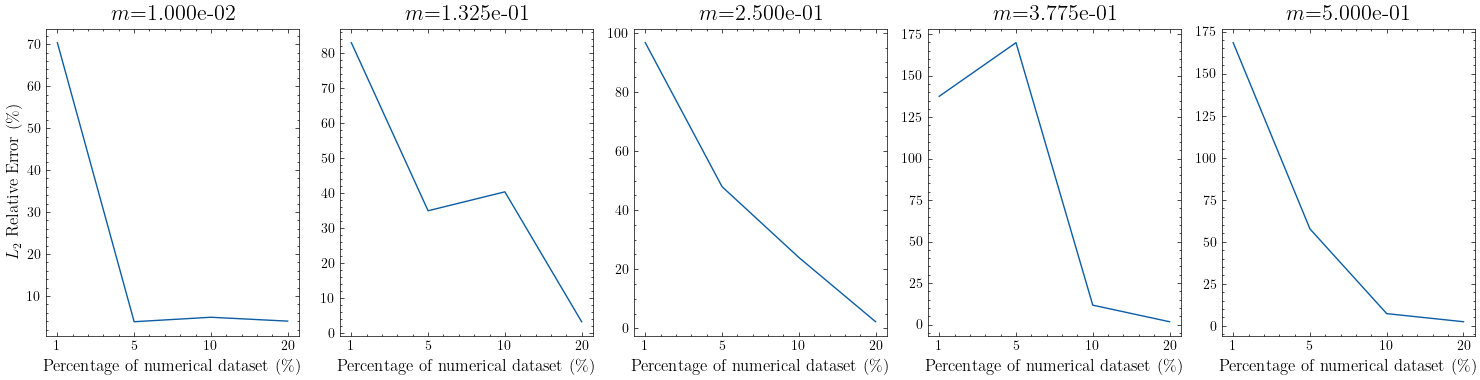

In [20]:
if NETWORK == "pinn":
    fig, ax = plt.subplots(1, len(PARAM_LIST), figsize=(15, 4))

    for idx, param in enumerate(PARAM_LIST):
        ax[idx].plot(range(1, 5), rel_error_semi_supervised[:, idx]*100)
        ax[idx].set_xticks(range(1, 5))
        ax[idx].set_xticklabels(["1", "5", "10", "20"])
        ax[idx].set_xlabel("Percentage of numerical dataset (\%)", fontsize=12)
        ax[idx].set_title(f'{VARYING_PARAM_NOTATION}='+f"{param:.3e}", fontsize=16)

        if idx == 0:
            ax[idx].set_ylabel("$L_2$ Relative Error (\%)", fontsize=12)

    plt.tight_layout()

else:
    fig, ax = plt.subplots(1, len(PARAM_LIST), figsize=(15, 4))

    for idx, param in enumerate(PARAM_LIST):
        ax[idx].plot(range(1, 5), rel_error_semi_supervised[:, idx]*100)
        ax[idx].set_xticks(range(1, 5))
        ax[idx].set_xticklabels(["1", "5", "10", "20"])
        ax[idx].set_xlabel("Percentage of numerical dataset (\%)", fontsize=12)
        ax[idx].set_title(f'{VARYING_PARAM_NOTATION}='+f"{param:.3e}", fontsize=16)

        if idx == 0:
            ax[idx].set_ylabel("$L_2$ Relative Error (\%)", fontsize=12)

    plt.tight_layout()

In [21]:
np.mean((rel_error_semi_supervised*100), axis=1)

array([111.19308472,  62.86046788,  17.63703324,   2.72783399])